In [68]:
import numpy as np
import scipy.sparse as sp
import pandas as pd

In [69]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

In [70]:
from sklearn.neighbors import KNeighborsRegressor

knn_clf = KNeighborsRegressor()

Define the task

Prepare data & split data

Choose the model

Train the model

Evaluate the model

Use the model

In [71]:
esol_df = pd.read_csv('data/esol.csv')
esol_df.head()

,smiles,log solubility (mol/L)
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


In [72]:
smiles = esol_df['smiles'].values
y = esol_df['log solubility (mol/L)'].values

smiles
y

array([-0.77 , -3.3  , -2.06 , ..., -3.091, -3.18 , -4.522])

In [73]:
from deepchem.feat import RDKitDescriptors

featurizer = RDKitDescriptors()
features = featurizer.featurize(smiles)
features.shape

(1128, 217)

In [74]:
print(f'Number of generated molecular descriptors: {features.shape[1]}')
features

Number of generated molecular descriptors: 217


array([[ 2.81312868,  2.47523823, -2.42509186, ...,  0.        ,
         0.        ,  0.21751779],
       [ 2.65822643,  2.10213709, -2.02528356, ...,  0.        ,
         0.        ,  0.81128275],
       [ 1.86876203,  1.86031507, -1.94442887, ...,  0.        ,
         0.        ,  0.34370646],
       ...,
       [ 2.12099818,  2.14274276, -2.15343675, ...,  0.        ,
         0.        ,  0.50606972],
       [ 1.37878349,  1.79531012, -1.90099928, ...,  0.        ,
         0.        ,  0.44444084],
       [ 2.4003692 ,  2.27135675, -2.16911981, ...,  0.        ,
         0.        ,  0.38662545]])

In [75]:
#Dropping features with NaN values
features = features[:, ~np.isnan(features).any(axis=0)]
print(f"Number of molecular descriptors without invalid values: {features.shape[1]}")
features.shape

Number of molecular descriptors without invalid values: 217


(1128, 217)

In [76]:
from deepchem.feat import MACCSKeysFingerprint
mf_featurizer = MACCSKeysFingerprint()
mf_features = mf_featurizer.featurize(smiles)
mf_features.shape

(1128, 167)

In [77]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
features = selector.fit_transform(features)
print(f"Number of molecular descriptors after removing zeo variance features: {features.shape[1]}")

Number of molecular descriptors after removing zeo variance features: 198


In [78]:
from sklearn.model_selection import train_test_split

X = features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train)

X_train_orignal = X_train
X_test_orignal = X_test

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [80]:
from sklearn.ensemble import RandomForestRegressor
ranf_reg = RandomForestRegressor(n_estimators=100, random_state=0)

from xgboost import XGBRegressor
xgb_reg = XGBRegressor(n_estimators=100, random_state=0)

In [81]:
from sklearn.metrics import mean_squared_error

def train_test_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    model_train_mse = mean_squared_error(y_train, y_pred_train)
    model_test_mse = mean_squared_error(y_test, y_pred_test)

    model_train_rmse = np.sqrt(model_train_mse)
    model_test_rmse = np.sqrt(model_test_mse)

    print(f"RMSE on training set: {model_train_rmse:.4f}, and test set: {model_test_rmse:.4f}")
    

In [82]:
print("Evaluating Random Forest Model")
train_test_model(ranf_reg, X_train, y_train, X_test, y_test)

print("Evaluating XGBoost Model")
train_test_model(xgb_reg, X_train, y_train, X_test, y_test)

Evaluating Random Forest Model
RMSE on training set: 0.2443, and test set: 0.6938
Evaluating XGBoost Model
RMSE on training set: 0.0281, and test set: 0.6739


XGBoost fits the training data much better.

XGBoost performs slightly better on the test set


XGBoost is heavily overfitting.
Random Forest is more stable / less overfitting.


XGBoost has the slightly better test RMSE, so it is technically better at prediction right now but XGBoost is overfitting much more

In [83]:
from sklearn.svm import SVR

svm_reg = SVR()

print("Evaluating SVM Model")
train_test_model(svm_reg, X_train, y_train, X_test, y_test)

Evaluating SVM Model
RMSE on training set: 0.5181, and test set: 0.7264


In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20, 30]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=0), 
    param_grid=param_grid, 
    cv=5
)
grid_search.fit(X_train, y_train)

rf_gs = RandomForestRegressor(**grid_search.best_params_, random_state=0)

print('Best hyperparameters found:', grid_search.best_params_)
print("Evaluating Tuned Random Forest Model")
train_test_model(rf_gs, X_train, y_train, X_test, y_test)

Best hyperparameters found: {'max_depth': 30, 'n_estimators': 50}
Evaluating Tuned Random Forest Model
RMSE on training set: 0.2434, and test set: 0.6868


CLASSIFICATION

In [85]:
df_toxicity = pd.read_csv('data/toxcast_data.csv')
df_toxicity.head(5)

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
df_tox = df_toxicity.loc[:, ['smiles', "TOX21_TR_LUC_GH3_Antagonist"]].dropna()
df_tox.columns = ['smiles', 'toxic']
df_tox.sample(5)

,smiles,toxic
7702,CN1C2=CC=C(Cl)C=C2C(=NC(O)C1=O)C1=CC=CC=C1,0.0
5696,[Na+].CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S([O...,1.0
822,C1CCCNCCC1,0.0
6185,COC1=CC=C(C=O)C=C1O,0.0
3614,COC(=O)CC1=C2C=CC=CC2=CC=C1,0.0


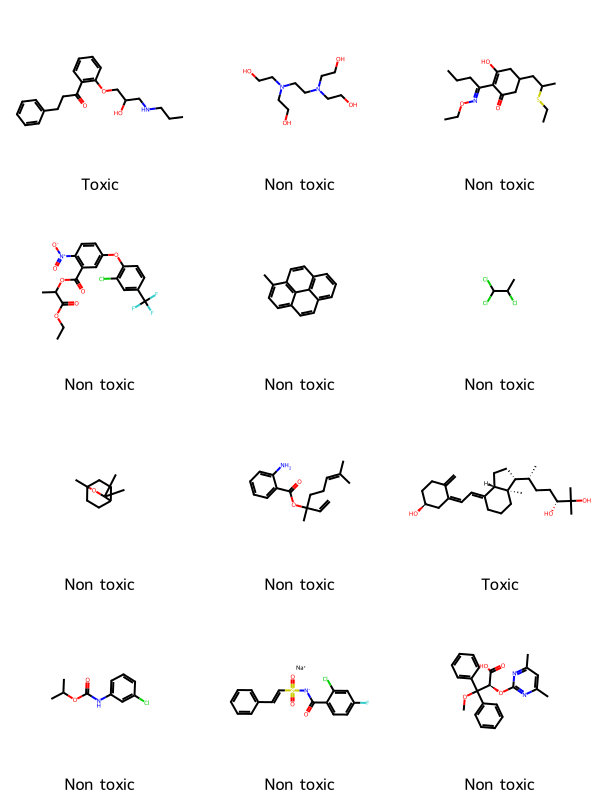

In [87]:
from rdkit import Chem
from rdkit.Chem import Draw

n = 12
df_sample = df_tox.sample(n)

smiles = df_sample['smiles'].values
legend = df_sample['toxic'].values
molecs = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(
    molecs,
    legends=["Toxic" if i==1 else "Non toxic" for i in legend]
)

In [88]:
counts = df_tox['toxic'].value_counts()

print(f"The dataset contains {counts[1]} toxic compounds and {counts[0]} non-toxic compounds.")

The dataset contains 1764 toxic compounds and 6186 non-toxic compounds.


In [89]:

from rdkit import Chem
import numpy as np
from deepchem.feat import MordredDescriptors

featurizer = MordredDescriptors(ignore_3D=True)
features = featurizer.featurize("CCC")
print("Number of molecular descriptors:", features.shape[1])

Number of molecular descriptors: 1613


In [90]:
X_raw = df_tox.smiles.apply(lambda x: featurizer.featurize(x))
y_raw = df_tox.toxic

c:\Users\aryan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
[00:43:28] Explicit valence for atom # 0 F, 1, is greater than permitted
Failed to featurize datapoint 0, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[00:44:28] Explicit valence for atom # 2 Cl, 1, is greater than permitted
Failed to featurize datapoint 0, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChi

In [ ]:
X_raw.shape

(7950,)

In [95]:
X_raw.head()

0    [[0.0, 0.0, 0.0, 0.0, 11.936237570137333, 2.23...
1    [[0.0, 0.0, 0.0, 0.0, 14.698195805856933, 2.32...
2    [[0.0, 0.0, 0.0, 1.0, 19.577708806106966, 2.32...
3    [[0.0, 0.0, 0.0, 0.0, 11.936237570137338, 2.23...
4    [[0.0, 0.0, 0.0, 0.0, 11.936237570137333, 2.23...
Name: smiles, dtype: object

In [96]:
missing = X_raw.apply(lambda x: x.shape == (1, features.shape[1]))
print(f"Number of molecules with missing features: {np.sum(~missing)}")

Number of molecules with missing features: 16


In [97]:
print(f"Dropping {np.sum(~missing)} molecules with missing features.")
X = X_raw[missing].values
y = y_raw[missing].values

X = np.concatenate(X)

np.save('data/features_tox.npy', X)
np.save('data/y_tox.npy', y)

Dropping 16 molecules with missing features.


In [98]:
X = np.load('data/features_tox.npy')
y = np.load('data/y_tox.npy')

In [103]:
# Challenge: Which molecules couldn't be featurized? Why?
# Using code from above, visualize the faulty molecules.

X_missing = X_raw[~missing]
X_missing.sample(16)

7185    [[]]
6611    [[]]
7950    [[]]
5993    [[]]
8182    [[]]
4781    [[]]
6909    [[]]
5098    [[]]
1789    [[]]
6625    [[]]
8047    [[]]
1039    [[]]
7338    [[]]
7862    [[]]
4175    [[]]
1881    [[]]
Name: smiles, dtype: object

In [104]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smile) for smile in X_missing]

Draw.MolsToGridImage(
    mols,
    legends=[smile for smile in X_missing]
)


TypeError: No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type numpy.ndarray